[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RonPlusSign/llms4subjects/blob/main/embedding_similarity_tagging.ipynb)

# Embedding Similarity Tagging

The goal of this notebook is to run the `embedding_similarity_tagging.py` script with different parameters (e.g. different embedding models).

The script uses a SentenceTransformer model to encode document texts and tag embeddings,
and then computes the similarity between them to tag the documents with the most similar GND tags.

The quality of the tagging results is evaluated using the `shared-task-eval-script/llms4subjects-evaluation.py` script.

In [ ]:
# If you run this notebook in Google Colab, run this

# Clone repository and move its content in the current directory
!git clone https://github.com/RonPlusSign/llms4subjects.git
!mv llms4subjects/* .
!rm -r llms4subjects

# Install required packages
!pip install -r requirements.txt

#### Tagging with Different Embedding Models

In [12]:
models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "distiluse-base-multilingual-cased-v1",
    "T-Systems-onsite/cross-en-de-roberta-sentence-transformer",  # this gives warning "No sentence-transformers model found with name ...", but it's ok
    "intfloat/multilingual-e5-large",
]

In [13]:
for model_name in models:
    model_name_folder = model_name.split("/")[-1]
    tag_embeddings_file = f"results/{model_name_folder}/tag_embeddings.json"  # Where to save the tag embeddings
    results_dir = f"results/{model_name_folder}"  # Where to save the tagging results
    docs_path = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"  # Documents to tag
    tag_file = "shared-task-datasets/GND/dataset/GND-Subjects-tib-core.json"  # Tag list definition

    print(f"\n------Running tagging with model: {model_name} ------")
    %run embedding_similarity_tagging.py \
            --model_name { model_name } \
            --tags_file { tag_file } \
            --tag_embeddings_file { tag_embeddings_file } \
            --results_dir { results_dir } \
            --docs_path { docs_path }


------Running tagging with model: sentence-transformers/all-MiniLM-L6-v2 ------


D:\andre\Desktop\llms4subjects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:17<00:00, 32.07it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:31<00:00, 46.21it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: distiluse-base-multilingual-cased-v1 ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [04:22<00:00,  9.46it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:41<00:00, 43.30it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: T-Systems-onsite/cross-en-de-roberta-sentence-transformer ------
Loading model...


No sentence-transformers model found with name T-Systems-onsite/cross-en-de-roberta-sentence-transformer. Creating a new one with mean pooling.


Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [09:01<00:00,  4.59it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [07:12<00:00, 16.14it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: intfloat/multilingual-e5-large ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [25:40<00:00,  1.61it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [20:48<00:00,  5.59it/s]


Tagging complete. Individual results saved in corresponding files.


#### Evaluation

In [14]:
# Evaluate the tagging results using the evaluation script.
for model_name in models:
    print(f"\n------Evaluating tagging results for model: {model_name} ------")

    model_name_folder = model_name.split("/")[-1]
    true_labels_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"
    pred_labels_dir = f"results/{model_name_folder}"
    results_dir = f"results/{model_name_folder}"

    %run "shared-task-eval-script/llms4subjects-evaluation.py" \
            --team_name { model_name_folder } \
            --true_labels_dir { true_labels_dir } \
            --pred_labels_dir { pred_labels_dir } \
            --results_dir { results_dir }


------Evaluating tagging results for model: sentence-transformers/all-MiniLM-L6-v2 ------

LLMs4Subjects Shared Task -- Evaluations

Reading the True GND labels...
Reading the Predicted GND labels...

Evaluating the directory structure of the predicted folder...

Evaluating the predicted GND labels...

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 5
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 5
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 5

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 10
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 10
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 10

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 15
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 15
Evaluating GND S

## SentenceTransformer fine-tuning

The `finetune_sentence_transformer.py` script fine-tunes a SentenceTransformer model on training data for subject tagging.

In [1]:
# List of models to fine-tune
models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    # "distiluse-base-multilingual-cased-v1",
    # "T-Systems-onsite/cross-en-de-roberta-sentence-transformer", # this gives warning "No sentence-transformers model found with name ...", but it's ok
    # "intfloat/multilingual-e5-large",
]

# Extract the base model names (e.g., from "sentence-transformers/all-MiniLM-L6-v2" take "all-MiniLM-L6-v2")
model_names = [model_name.split("/")[-1] for model_name in models]

# Define the list of losses to test
losses = ["coSENT", "AnglE", "CosineSimilarity", "MultipleNegativesRanking", "Triplet"]

#### Execute fine-tuning

In [2]:
# Finetune all SentenceTransformer models on the training data for each loss function
for model_name in models:
    print(f"\n------Fine-tuning model: {model_name} ------")
    model_name_clean = model_name.split("/")[-1]

    # Common directories and files
    training_data_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/train"
    eval_data_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"
    gnd_tags_file = "shared-task-datasets/GND/dataset/GND-Subjects-tib-core.json"

    for loss in losses:
        # Modify the output path to include the loss function name
        output_model_path = f"models/finetuned/{model_name_clean}_{loss}"
        print(f"Using loss: {loss}, saving to: {output_model_path}")

        # Run the fine-tuning script with the specified loss
        %run finetune_sentence_transformer.py \
                --training_path { training_data_dir } \
                --eval_path { eval_data_dir } \
                --gnd_tags_file { gnd_tags_file } \
                --model_name { model_name } \
                --output_model_path { output_model_path } \
                --batch_size 16 \
                --num_epochs 1 \
                --loss { loss }


------Fine-tuning model: sentence-transformers/all-MiniLM-L6-v2 ------
Using loss: coSENT, saving to: models/finetuned/all-MiniLM-L6-v2_coSENT


D:\andre\Desktop\llms4subjects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading model...
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.


Starting fine-tuning...


wandb: Currently logged in as: andrea-delli (andrea-delli-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss
1000,2.408500,0.669412
2000,1.927000,0.588041
3000,1.729700,0.451133
4000,1.480000,0.460791
5000,1.260500,0.368131
6000,1.298800,0.399303
7000,1.173900,0.355184
8000,1.002100,0.311243
9000,1.057100,0.293465
10000,1.021500,0.274140


Fine-tuning complete. Model saved to models/finetuned/all-MiniLM-L6-v2_coSENT.


eval/loss,█▇▄▄▃▃▂▂▁▁
eval/runtime,▂▁▁▅█▅▅▆▂▁
eval/samples_per_second,▇██▄▁▄▃▃▇█
eval/steps_per_second,▇██▄▁▄▃▃▇█
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▂▂▇▂▅▁▃▁█▁
train/learning_rate,██▇▆▅▄▄▃▂▁
train/loss,█▆▅▃▂▂▂▁▁▁
eval/loss,0.27414
eval/runtime,173.9312


Using loss: AnglE, saving to: models/finetuned/all-MiniLM-L6-v2_AnglE
Using device: cuda
Loading model...
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.


Starting fine-tuning...


Step,Training Loss,Validation Loss
1000,2.708900,0.726152
2000,2.000800,0.685210
3000,1.825400,0.507084
4000,1.544500,0.505828
5000,1.346300,0.416654
6000,1.377200,0.419160
7000,1.252200,0.369957
8000,1.052100,0.352722
9000,1.054700,0.339808
10000,1.045600,0.306802


Fine-tuning complete. Model saved to models/finetuned/all-MiniLM-L6-v2_AnglE.


eval/loss,█▇▄▄▃▃▂▂▂▁
eval/runtime,▄█▃▃▃▂▂▁▄▂
eval/samples_per_second,▅▁▆▆▆▇▇█▅▇
eval/steps_per_second,▅▁▆▆▆▇▇█▅▇
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▅▄▃▂▆▁▇▁█▁
train/learning_rate,██▇▆▅▄▄▃▂▁
train/loss,█▅▄▃▂▂▂▁▁▁
eval/loss,0.3068
eval/runtime,193.2063


Using loss: CosineSimilarity, saving to: models/finetuned/all-MiniLM-L6-v2_CosineSimilarity
Using device: cuda
Loading model...
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.


Starting fine-tuning...


Step,Training Loss,Validation Loss
1000,0.118900,0.083757
2000,0.079900,0.067603
3000,0.070200,0.064060
4000,0.064700,0.059908
5000,0.058600,0.058677
6000,0.059900,0.056789
7000,0.056500,0.053862
8000,0.052800,0.052989
9000,0.053600,0.050934
10000,0.052600,0.050552


Fine-tuning complete. Model saved to models/finetuned/all-MiniLM-L6-v2_CosineSimilarity.


eval/loss,█▅▄▃▃▂▂▂▁▁
eval/runtime,▁▁▁█▇▇▇▇▆▃
eval/samples_per_second,███▁▂▂▂▂▃▆
eval/steps_per_second,███▁▂▂▂▂▃▆
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▅▄▄▄█▁▅▂▆▁
train/learning_rate,██▇▆▅▄▄▃▂▁
train/loss,█▄▃▂▂▂▁▁▁▁
eval/loss,0.05055
eval/runtime,205.5515


Using loss: MultipleNegativesRanking, saving to: models/finetuned/all-MiniLM-L6-v2_MultipleNegativesRanking
Using device: cuda
Loading model...
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.


Starting fine-tuning...


Step,Training Loss,Validation Loss
1000,0.863500,0.407056
2000,0.652200,0.335982
3000,0.576000,0.302286
4000,0.528300,0.279303
5000,0.481300,0.264122


Fine-tuning complete. Model saved to models/finetuned/all-MiniLM-L6-v2_MultipleNegativesRanking.


eval/loss,█▅▃▂▁
eval/runtime,▆▁▃█▆
eval/samples_per_second,▃█▆▁▃
eval/steps_per_second,▃█▆▁▃
train/epoch,▁▁▃▃▄▄▆▆▇▇█
train/global_step,▁▁▃▃▄▄▆▆▇▇█
train/grad_norm,▇▆▅█▁
train/learning_rate,█▆▄▃▁
train/loss,█▄▃▂▁
eval/loss,0.26412
eval/runtime,108.057


Using loss: Triplet, saving to: models/finetuned/all-MiniLM-L6-v2_Triplet
Using device: cuda
Loading model...
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.


Starting fine-tuning...


Step,Training Loss,Validation Loss
1000,4.146700,3.918621
2000,3.855800,3.748374
3000,3.779700,3.729603
4000,3.750900,3.691578
5000,3.721100,3.691401


Fine-tuning complete. Model saved to models/finetuned/all-MiniLM-L6-v2_Triplet.


eval/loss,█▃▂▁▁
eval/runtime,▁▂▁▁█
eval/samples_per_second,█▇██▁
eval/steps_per_second,█▇██▁
train/epoch,▁▁▃▃▄▄▆▆▇▇█
train/global_step,▁▁▃▃▄▄▆▆▇▇█
train/grad_norm,▃▁█▁▁
train/learning_rate,█▆▄▃▁
train/loss,█▃▂▁▁
eval/loss,3.6914
eval/runtime,136.7844


#### Tag using the fine-tuned models

In [2]:
# For each model and each loss, run tagging
for model_name in model_names:
    for loss in losses:
        # Construct the path where the finetuned model is saved
        finetuned_model_path = f"models/finetuned/{model_name}_{loss}"
        # Use a folder name that includes both the model and loss to save the tagging results
        model_name_folder = f"{model_name}_{loss}"
        tag_embeddings_file = f"results/finetuned_{model_name_folder}/tag_embeddings.json"  # Where to save the tag embeddings
        results_dir = f"results/finetuned_{model_name_folder}"  # Where to save the tagging results
        docs_path = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"  # Documents to tag
        tag_file = "shared-task-datasets/GND/dataset/GND-Subjects-tib-core.json"  # Tag list definition

        print(f"\n------Running tagging with model: {finetuned_model_path} (loss: {loss}) ------")
        %run embedding_similarity_tagging.py \
                --model_name { finetuned_model_path } \
                --tags_file { tag_file } \
                --tag_embeddings_file { tag_embeddings_file } \
                --results_dir { results_dir } \
                --docs_path { docs_path }


------Running tagging with model: models/finetuned/all-MiniLM-L6-v2_coSENT (loss: coSENT) ------


D:\andre\Desktop\llms4subjects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:16<00:00, 32.45it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [03:11<00:00, 36.38it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: models/finetuned/all-MiniLM-L6-v2_AnglE (loss: AnglE) ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:17<00:00, 31.91it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:54<00:00, 40.04it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: models/finetuned/all-MiniLM-L6-v2_CosineSimilarity (loss: CosineSimilarity) ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:16<00:00, 32.53it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:48<00:00, 41.32it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: models/finetuned/all-MiniLM-L6-v2_MultipleNegativesRanking (loss: MultipleNegativesRanking) ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:15<00:00, 32.73it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:16<00:00, 50.95it/s]


Tagging complete. Individual results saved in corresponding files.

------Running tagging with model: models/finetuned/all-MiniLM-L6-v2_Triplet (loss: Triplet) ------
Loading model...
Loading GND tags...
Encoding tag descriptions...


Batches: 100%|██████████| 2483/2483 [01:15<00:00, 32.93it/s]


Processing test documents and computing similarities...
Found 6980 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev.


Tagging documents: 100%|██████████| 6980/6980 [02:17<00:00, 50.70it/s]

Tagging complete. Individual results saved in corresponding files.


#### Evaluate the fine-tuned models

In [3]:
# Evaluate each fine-tuned models (i.e. for each model-loss combination)
for model_name in model_names:
    for loss in losses:
        # Build the fine-tuned model path used during training
        finetuned_model_path = f"models/finetuned/{model_name}_{loss}"
        # Create a unique folder name that includes both model name and loss
        model_name_clean = f"{model_name}_{loss}"
        true_labels_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"
        pred_labels_dir = f"results/finetuned_{model_name_clean}"
        results_dir = f"results/finetuned_{model_name_clean}"
        result_name = f"finetuned_{model_name_clean}"

        print(f"\n------Evaluating fine-tuned model: {finetuned_model_path} (loss: {loss}) ------")
        %run "shared-task-eval-script/llms4subjects-evaluation.py" \
                --team_name { result_name } \
                --true_labels_dir { true_labels_dir } \
                --pred_labels_dir { pred_labels_dir } \
                --results_dir { results_dir }


------Evaluating fine-tuned model: models/finetuned/all-MiniLM-L6-v2_coSENT (loss: coSENT) ------

LLMs4Subjects Shared Task -- Evaluations

Reading the True GND labels...
Reading the Predicted GND labels...

Evaluating the directory structure of the predicted folder...

Evaluating the predicted GND labels...

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 5
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 5
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 5

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 10
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 10
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 10

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 15
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 15
Evaluati

## Use MLP instead of cosine similarity for tagging

#### Train the MLP models

D:\andre\Desktop\llms4subjects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading model...
Model loaded.
Loading GND tags and building mapping...
Loaded 79427 GND tags.
Building training examples...
Created 87896 training examples.
Building evaluation examples...
Created 14711 evaluation examples.
Getting embeddings...
Embeddings obtained.
Epoch 1, Iteration 2000, Loss: 0.6564528861492872
Epoch 1, Iteration 4000, Loss: 0.6068995882049203
Epoch 1, Iteration 6000, Loss: 0.5736473851129412
Epoch 1, Iteration 8000, Loss: 0.5465066463481635
Epoch 1, Iteration 10000, Loss: 0.5194058103859425
	Validation: Iteration 500, Loss: 0.28230462488532065
	Validation: Iteration 1000, Loss: 0.31006703671813013
	Validation: Iteration 1500, Loss: 0.3272780604014794
End of epoch 1, Training loss: 0.5063250544400876, Validation Loss: 0.3391969763370491
--------------------------------------------------
Epoch 2, Iteration 2000, Loss: 0.3494936836473644
Epoch 2, Iteration 4000, Loss: 0.337196472780779
Epoch 2, Iteration 6000, Loss: 0.3283813926906635
Epoch 2, Ite

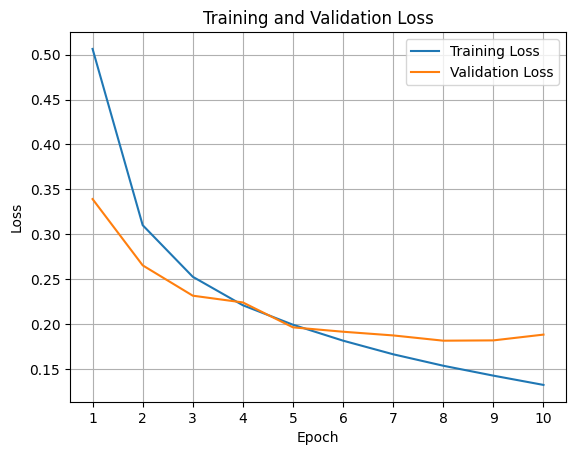

In [1]:
model_name = "all-MiniLM-L6-v2"

model_name_clean = model_name.split("/")[-1]
model_path = f"{model_name_clean}"
training_data_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/train"
eval_data_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev"
gnd_tags_file = "shared-task-datasets/GND/dataset/GND-Subjects-tib-core.json"

%run binary_mlp.py \
        --training_path {training_data_dir} \
        --eval_path {eval_data_dir} \
        --gnd_tags_file {gnd_tags_file} \
        --model_name {model_path} \
        --batch_size 16 \
        --num_epochs 10

#### Tag using the embedding models + MLP to measure similarity

In [2]:
model_name_folder = model_name.split("/")[-1]
tag_embeddings_file = f"results/mlp_{model_name_folder}/tag_embeddings.json"  # Where to save the tag embeddings
doc_embeddings_file = f"embeddings/mlp_{model_name_folder}/Thesis_doc_embeddings.pt"  # Where to save the document embeddings
results_dir = f"results/mlp_{model_name_folder}/Thesis"  # Where to save the tagging results
docs_path = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev/Thesis"  # Documents to tag
tag_file = "shared-task-datasets/GND/dataset/GND-Subjects-tib-core.json"  # Tag list definition
mlp_model = f"models/mlp/{model_name_folder}.pth"

print(f"\n------Running tagging with model: {model_name} ------")
%run embedding_similarity_tagging.py \
        --model_name { model_name } \
        --tags_file { tag_file } \
        --tag_embeddings_file { tag_embeddings_file } \
        --doc_embeddings_file { doc_embeddings_file } \
        --results_dir { results_dir } \
        --docs_path { docs_path } \
        --mlp_model { mlp_model }


------Running tagging with model: all-MiniLM-L6-v2 ------
Loading model...
Loading GND tags...
Processing test documents and computing similarities...
Found 1038 documents in shared-task-datasets/TIBKAT/tib-core-subjects/data/dev/Thesis.


Tagging documents: 100%|██████████| 1038/1038 [10:48<00:00,  1.60it/s]

Tagging complete. Individual results saved in corresponding files.


#### Evaluate embedding+MLP models

In [4]:
# Evaluate the tagging results of embedding+MLP models using the evaluation script

# Build the fine-tuned model path used during training
# Create a unique folder name that includes both model name and loss
true_labels_dir = "shared-task-datasets/TIBKAT/tib-core-subjects/data/dev/Thesis"
pred_labels_dir = f"results/mlp_{model_name_folder}/Thesis"
results_dir = f"results/mlp_{model_name_folder}/Thesis"
result_name = f"mlp_{model_name_folder}_Thesis"

print(f"\n------Evaluating fine-tuned model: {model_name_folder} ------")
%run "shared-task-eval-script/llms4subjects-evaluation.py" \
        --team_name { result_name } \
        --true_labels_dir { true_labels_dir } \
        --pred_labels_dir { pred_labels_dir } \
        --results_dir { results_dir }


------Evaluating fine-tuned model: all-MiniLM-L6-v2 ------

LLMs4Subjects Shared Task -- Evaluations

Reading the True GND labels...
Reading the Predicted GND labels...
Exception Occured: 'utf-8' codec can't decode byte 0xaf in position 10: invalid start byte

Evaluating the directory structure of the predicted folder...

Evaluating the predicted GND labels...

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 5
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 5
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 5

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 10
Evaluating GND Subject Codes -- Granularity Level: Record Type level and k: 10
Evaluating GND Subject Codes -- Granularity Level: Language level and k: 10

Evaluating GND Subject Codes -- Granularity Level: Combined Language and Record-levels and k: 15
Evaluating GND Subject Codes -- Gra